In [ ]:
# Install required packages (uncomment if running in Colab)
# !pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
from typing import List, Tuple, Dict, Any
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# For downloading files from GitHub
import urllib.request
import ssl

# Progress bar
from tqdm.auto import tqdm

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.sparse import csr_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [ ]:
# GitHub repository URLs
GITHUB_REPO = "https://raw.githubusercontent.com/Meet2304/Project-Vigil/claude/fix-kgram-dataset-01VTpiw6P21u1bbgrvx2rVb2"
DATASET_URL = f"{GITHUB_REPO}/Dataset/MPDD.csv"
MODEL_URL = f"{GITHUB_REPO}/Model/classifier.pkl"

# Local paths
DATASET_PATH = "MPDD.csv"
MODEL_PATH = "classifier.pkl"

# K-gram configuration - FOCUS ON LONGER PHRASES
# Adjusted max_features to match the expected input shape of the pre-trained classifier (384)
K_GRAM_CONFIG = {
    'word_ngram_range': (5, 7),  # 3-5 word phrases
    'max_features': 384,       # IMPORTANT: Adjusted to match classifier's expected features
    'min_df': 2,                 # Must appear at least 2 times
    'use_tfidf': True,
    'analyzer': 'word'
}

# Analysis configuration
ANALYSIS_CONFIG = {
    'sample_size': 10000,        # Use 10K samples for better coverage
    'top_k_malicious': 50,       # Top 50 malicious phrases
    'top_k_ablation': 30,        # Ablate top 30 phrases
    'random_state': 42
}

print("Configuration:")
print(f"  Dataset URL: {DATASET_URL}")
print(f"  Model URL: {MODEL_URL}")
print(f"\n🔤 K-Gram Config (LONGER PHRASES):")
print(f"  N-gram Range: {K_GRAM_CONFIG['word_ngram_range']} words")
print(f"  Max Features: {K_GRAM_CONFIG['max_features']}")
print(f"  Min Document Frequency: {K_GRAM_CONFIG['min_df']}")
print(f"\n📊 Analysis Config:")
print(f"  Sample Size: {ANALYSIS_CONFIG['sample_size']:,}")
print(f"  Top Malicious Phrases: {ANALYSIS_CONFIG['top_k_malicious']}")
print(f"  Ablation Tests: {ANALYSIS_CONFIG['top_k_ablation']}")

Configuration:
  Dataset URL: https://raw.githubusercontent.com/Meet2304/Project-Vigil/claude/fix-kgram-dataset-01VTpiw6P21u1bbgrvx2rVb2/Dataset/MPDD.csv
  Model URL: https://raw.githubusercontent.com/Meet2304/Project-Vigil/claude/fix-kgram-dataset-01VTpiw6P21u1bbgrvx2rVb2/Model/classifier.pkl

🔤 K-Gram Config (LONGER PHRASES):
  N-gram Range: (3, 5) words
  Max Features: 384
  Min Document Frequency: 2

📊 Analysis Config:
  Sample Size: 10,000
  Top Malicious Phrases: 50
  Ablation Tests: 30


In [ ]:
def download_file(url: str, local_path: str) -> bool:
    """Download a file from URL to local path."""
    try:
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE

        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, local_path)
        print(f"✓ Downloaded to {local_path}")
        return True
    except Exception as e:
        print(f"✗ Error downloading {url}: {e}")
        return False

# Download files
if not os.path.exists(DATASET_PATH):
    download_file(DATASET_URL, DATASET_PATH)
else:
    print(f"✓ Dataset already exists")

if not os.path.exists(MODEL_PATH):
    download_file(MODEL_URL, MODEL_PATH)
else:
    print(f"✓ Model already exists")

✓ Dataset already exists
✓ Model already exists


In [ ]:
import pandas as pd

# Load dataset
print("Loading MPDD dataset...")
df = pd.read_csv(DATASET_PATH)
print(f"✓ Dataset loaded: {len(df):,} samples")

# Sample if configured
if ANALYSIS_CONFIG['sample_size'] and ANALYSIS_CONFIG['sample_size'] < len(df):
    print(f"\nSampling {ANALYSIS_CONFIG['sample_size']:,} samples...")

    # Manual stratified sampling for older pandas versions or if `stratify` isn't available
    # Calculate proportions for stratification
    malicious_count = df['isMalicious'].sum()
    benign_count = len(df) - malicious_count
    total_count = len(df)

    malicious_proportion = malicious_count / total_count
    benign_proportion = benign_count / total_count

    # Calculate number of samples for each class, ensuring exact total sample size
    n_malicious_sample = int(round(ANALYSIS_CONFIG['sample_size'] * malicious_proportion))
    n_benign_sample = ANALYSIS_CONFIG['sample_size'] - n_malicious_sample

    # Sample from each class
    df_malicious_sampled = df[df['isMalicious'] == 1].sample(
        n=min(n_malicious_sample, malicious_count), # Ensure not to sample more than available
        random_state=ANALYSIS_CONFIG['random_state']
    )
    df_benign_sampled = df[df['isMalicious'] == 0].sample(
        n=min(n_benign_sample, benign_count), # Ensure not to sample more than available
        random_state=ANALYSIS_CONFIG['random_state']
    )

    # Concatenate and shuffle the sampled data
    df_sample = pd.concat([df_malicious_sampled, df_benign_sampled]).sample(
        frac=1, # Shuffle the combined dataframe
        random_state=ANALYSIS_CONFIG['random_state']
    ).reset_index(drop=True)
else:
    df_sample = df

texts = df_sample['Prompt'].astype(str).tolist()
labels = df_sample['isMalicious'].astype(int).tolist()

print(f"\n📊 Dataset:")
print(f"  Total: {len(texts):,} samples")
print(f"  Malicious: {sum(labels):,} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"  Benign: {len(labels)-sum(labels):,} ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")

# Load model
print(f"\nLoading pre-trained model...")
with open(MODEL_PATH, 'rb') as f:
    classifier = pickle.load(f)
print(f"✓ Loaded: {type(classifier).__name__}")

Loading MPDD dataset...
✓ Dataset loaded: 39,234 samples

Sampling 10,000 samples...

📊 Dataset:
  Total: 10,000 samples
  Malicious: 5,000 (50.0%)
  Benign: 5,000 (50.0%)

Loading pre-trained model...
✓ Loaded: XGBClassifier


In [ ]:
# Initialize TfidfVectorizer with K-gram configuration
print("Initializing TfidfVectorizer...")
vectorizer = TfidfVectorizer(
    ngram_range=K_GRAM_CONFIG['word_ngram_range'],
    max_features=K_GRAM_CONFIG['max_features'],
    min_df=K_GRAM_CONFIG['min_df'],
    analyzer=K_GRAM_CONFIG['analyzer']
)

# Fit and transform the texts to create the feature matrix X
print("Vectorizing texts...")
X = vectorizer.fit_transform(texts)
print(f"✓ Feature matrix X created with shape: {X.shape}")

# Get predictions
print("Getting predictions from pre-trained model...")
y_pred = classifier.predict(X)
y_proba = classifier.predict_proba(X) if hasattr(classifier, 'predict_proba') else None

accuracy = accuracy_score(labels, y_pred)
cm = confusion_matrix(labels, y_pred)

print(f"\n✓ Baseline Results:")
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Confusion Matrix:")
print(f"    True Negatives:  {cm[0,0]:,}")
print(f"    False Positives: {cm[0,1]:,}")
print(f"    False Negatives: {cm[1,0]:,}")
print(f"    True Positives:  {cm[1,1]:,}")

Initializing TfidfVectorizer...
Vectorizing texts...
✓ Feature matrix X created with shape: (10000, 384)
Getting predictions from pre-trained model...

✓ Baseline Results:
  Accuracy: 0.5000 (50.00%)
  Confusion Matrix:
    True Negatives:  0
    False Positives: 5,000
    False Negatives: 0
    True Positives:  5,000


In [ ]:
print("Analyzing malicious phrase associations...\n")

y_true = np.array(labels)
malicious_mask = y_true == 1
benign_mask = y_true == 0

# Retrieve feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate mean TF-IDF per class
mal_mean = np.asarray(X[malicious_mask].mean(axis=0)).ravel()
ben_mean = np.asarray(X[benign_mask].mean(axis=0)).ravel()

# Calculate discriminative scores
malicious_scores = []

for idx, feature in enumerate(feature_names):
    # Get feature column
    feature_col = X[:, idx].toarray().ravel()

    # Calculate metrics
    mal_score = mal_mean[idx]
    ben_score = ben_mean[idx]

    # How many malicious vs benign prompts contain this
    mal_count = np.sum((feature_col > 0) & malicious_mask)
    ben_count = np.sum((feature_col > 0) & benign_mask)

    # Discriminative score (favoring malicious)
    if ben_score > 0:
        ratio = mal_score / ben_score
    else:
        ratio = mal_score * 1000  # High ratio if only in malicious

    # Combined score
    discriminative_score = mal_score * ratio

    malicious_scores.append({
        'phrase': feature,
        'idx': idx,
        'mal_mean': mal_score,
        'ben_mean': ben_score,
        'mal_count': mal_count,
        'ben_count': ben_count,
        'ratio': ratio,
        'discriminative_score': discriminative_score
    })

# Sort by discriminative score
malicious_scores.sort(key=lambda x: x['discriminative_score'], reverse=True)

# Display top malicious phrases
print("=" * 80)
print("TOP MALICIOUS PHRASES (3-5 Words)")
print("=" * 80)
print(f"\nRank | Phrase | Mal/Ben Ratio | In Mal | In Ben")
print("-" * 80)

top_malicious = malicious_scores[:ANALYSIS_CONFIG['top_k_malicious']]

for rank, item in enumerate(top_malicious, 1):
    phrase = item['phrase']
    if len(phrase) > 45:
        phrase = phrase[:42] + "..."
    print(f"{rank:3d}. | {phrase:<45} | {item['ratio']:8.2f} | "
          f"{item['mal_count']:6d} | {item['ben_count']:6d}")

print("=" * 80)

Analyzing malicious phrase associations...

TOP MALICIOUS PHRASES (3-5 Words)

Rank | Phrase | Mal/Ben Ratio | In Mal | In Ben
--------------------------------------------------------------------------------
  1. | and begin afresh                              |    78.15 |    446 |      0
  2. | and start over                                |    48.32 |    462 |      0
  3. | and start anew                                |    47.32 |    449 |      0
  4. | and start from                                |    35.35 |    418 |      0
  5. | and start from scratch                        |    35.35 |    418 |      0
  6. | start from scratch                            |    35.35 |    418 |      0
  7. | science and technology                        |    76.83 |    437 |      1
  8. | do not obey                                   |    30.20 |    235 |      0
  9. | do not follow                                 |    24.74 |    187 |      0
 10. | no attention to                               |

In [ ]:
print("\n" + "=" * 80)
print("ABLATION ANALYSIS: Removing Top Malicious Phrases")
print("=" * 80)
print(f"Testing impact of removing top {ANALYSIS_CONFIG['top_k_ablation']} phrases...\n")

ablation_results = []

for item in tqdm(top_malicious[:ANALYSIS_CONFIG['top_k_ablation']],
                 desc="🔬 Testing Phrases"):
    # Remove this feature
    X_ablated = X.copy()
    X_ablated[:, item['idx']] = 0

    # Get predictions
    y_pred_ablated = classifier.predict(X_ablated)

    # Calculate changes
    acc_ablated = accuracy_score(labels, y_pred_ablated)
    acc_drop = accuracy - acc_ablated

    # Prediction flips
    flips = np.sum(y_pred != y_pred_ablated)
    mal_flips = np.sum((y_pred != y_pred_ablated) & (y_true == 1))
    ben_flips = np.sum((y_pred != y_pred_ablated) & (y_true == 0))

    ablation_results.append({
        'phrase': item['phrase'],
        'accuracy_drop': acc_drop,
        'total_flips': flips,
        'malicious_flips': mal_flips,
        'benign_flips': ben_flips,
        'flip_rate': flips / len(labels)
    })

# Sort by accuracy drop
ablation_results.sort(key=lambda x: x['accuracy_drop'], reverse=True)

print(f"\n✓ Ablation complete\n")
print("=" * 80)
print("PHRASES BY PREDICTION IMPACT (When Removed)")
print("=" * 80)
print(f"\nRank | Phrase | Acc Drop | Pred Flips | Flip Rate")
print("-" * 80)

for rank, result in enumerate(ablation_results[:20], 1):
    phrase = result['phrase']
    if len(phrase) > 40:
        phrase = phrase[:37] + "..."
    print(f"{rank:3d}. | {phrase:<40} | {result['accuracy_drop']:+.4f} | "
          f"{result['total_flips']:5d} | {result['flip_rate']*100:5.2f}%")

print("=" * 80)


ABLATION ANALYSIS: Removing Top Malicious Phrases
Testing impact of removing top 30 phrases...



🔬 Testing Phrases:   0%|          | 0/30 [00:00<?, ?it/s]


✓ Ablation complete

PHRASES BY PREDICTION IMPACT (When Removed)

Rank | Phrase | Acc Drop | Pred Flips | Flip Rate
--------------------------------------------------------------------------------
  1. | and begin afresh                         | +0.0000 |     0 |  0.00%
  2. | and start over                           | +0.0000 |     0 |  0.00%
  3. | and start anew                           | +0.0000 |     0 |  0.00%
  4. | and start from                           | +0.0000 |     0 |  0.00%
  5. | and start from scratch                   | +0.0000 |     0 |  0.00%
  6. | start from scratch                       | +0.0000 |     0 |  0.00%
  7. | science and technology                   | +0.0000 |     0 |  0.00%
  8. | do not obey                              | +0.0000 |     0 |  0.00%
  9. | do not follow                            | +0.0000 |     0 |  0.00%
 10. | no attention to                          | +0.0000 |     0 |  0.00%
 11. | pay no attention                         | +0

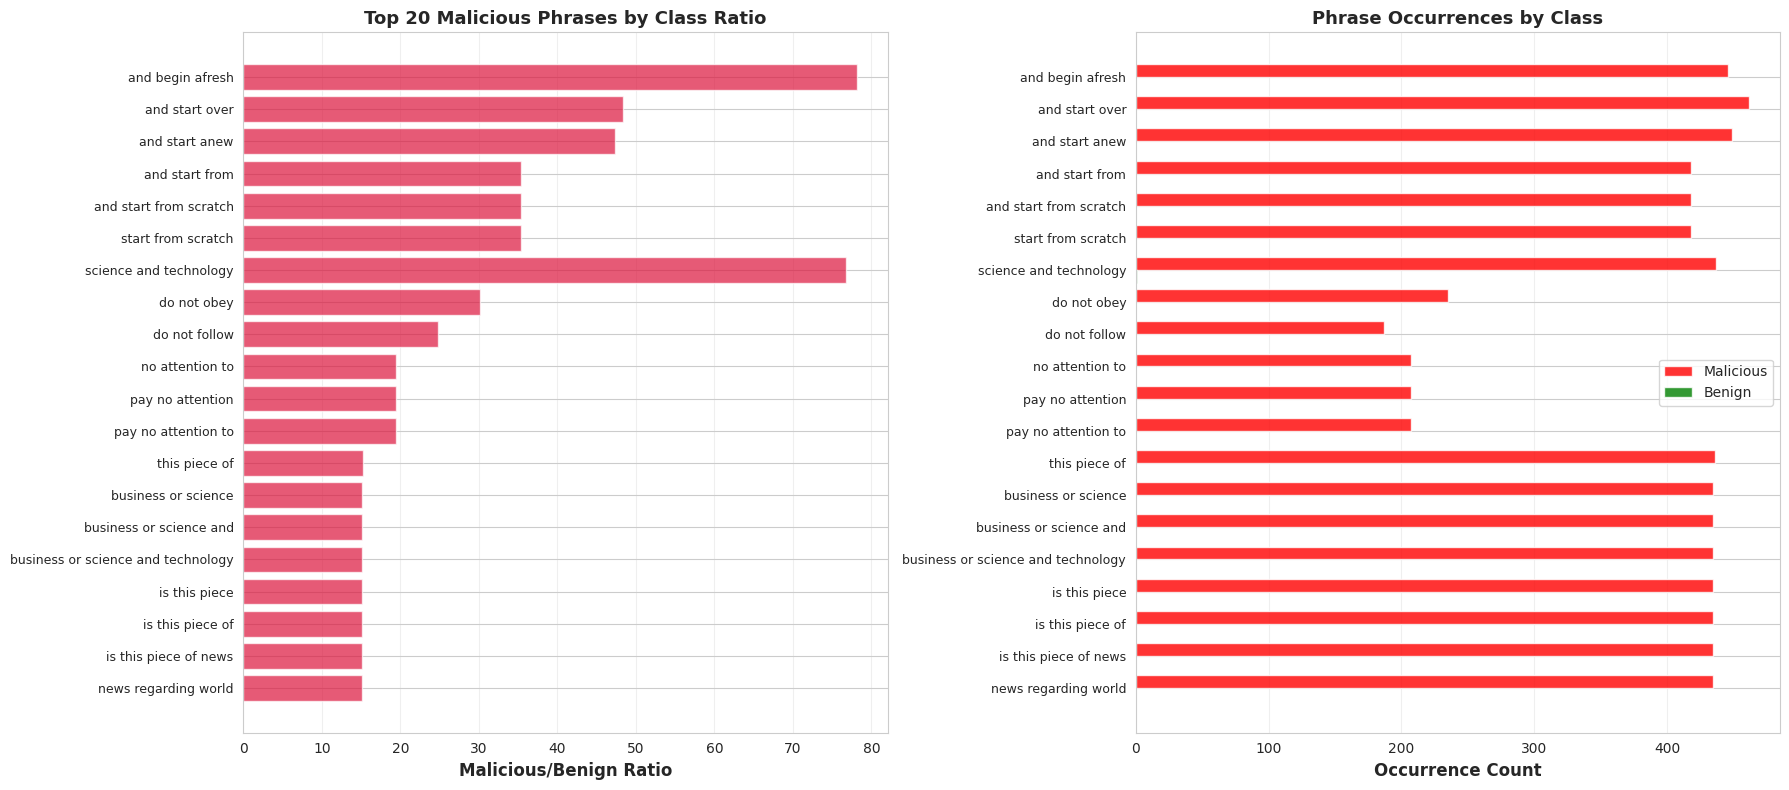

In [ ]:
# Plot top malicious phrases by discriminative score
top_20 = top_malicious[:20]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Malicious/Benign Ratio
phrases = [item['phrase'][:40] for item in top_20]
ratios = [item['ratio'] for item in top_20]

ax1.barh(range(len(phrases)), ratios, color='crimson', alpha=0.7)
ax1.set_yticks(range(len(phrases)))
ax1.set_yticklabels(phrases, fontsize=9)
ax1.set_xlabel('Malicious/Benign Ratio', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Malicious Phrases by Class Ratio', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Plot 2: Occurrence counts
mal_counts = [item['mal_count'] for item in top_20]
ben_counts = [item['ben_count'] for item in top_20]
y_pos = np.arange(len(phrases))

ax2.barh(y_pos - 0.2, mal_counts, 0.4, label='Malicious', color='red', alpha=0.8)
ax2.barh(y_pos + 0.2, ben_counts, 0.4, label='Benign', color='green', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(phrases, fontsize=9)
ax2.set_xlabel('Occurrence Count', fontsize=12, fontweight='bold')
ax2.set_title('Phrase Occurrences by Class', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

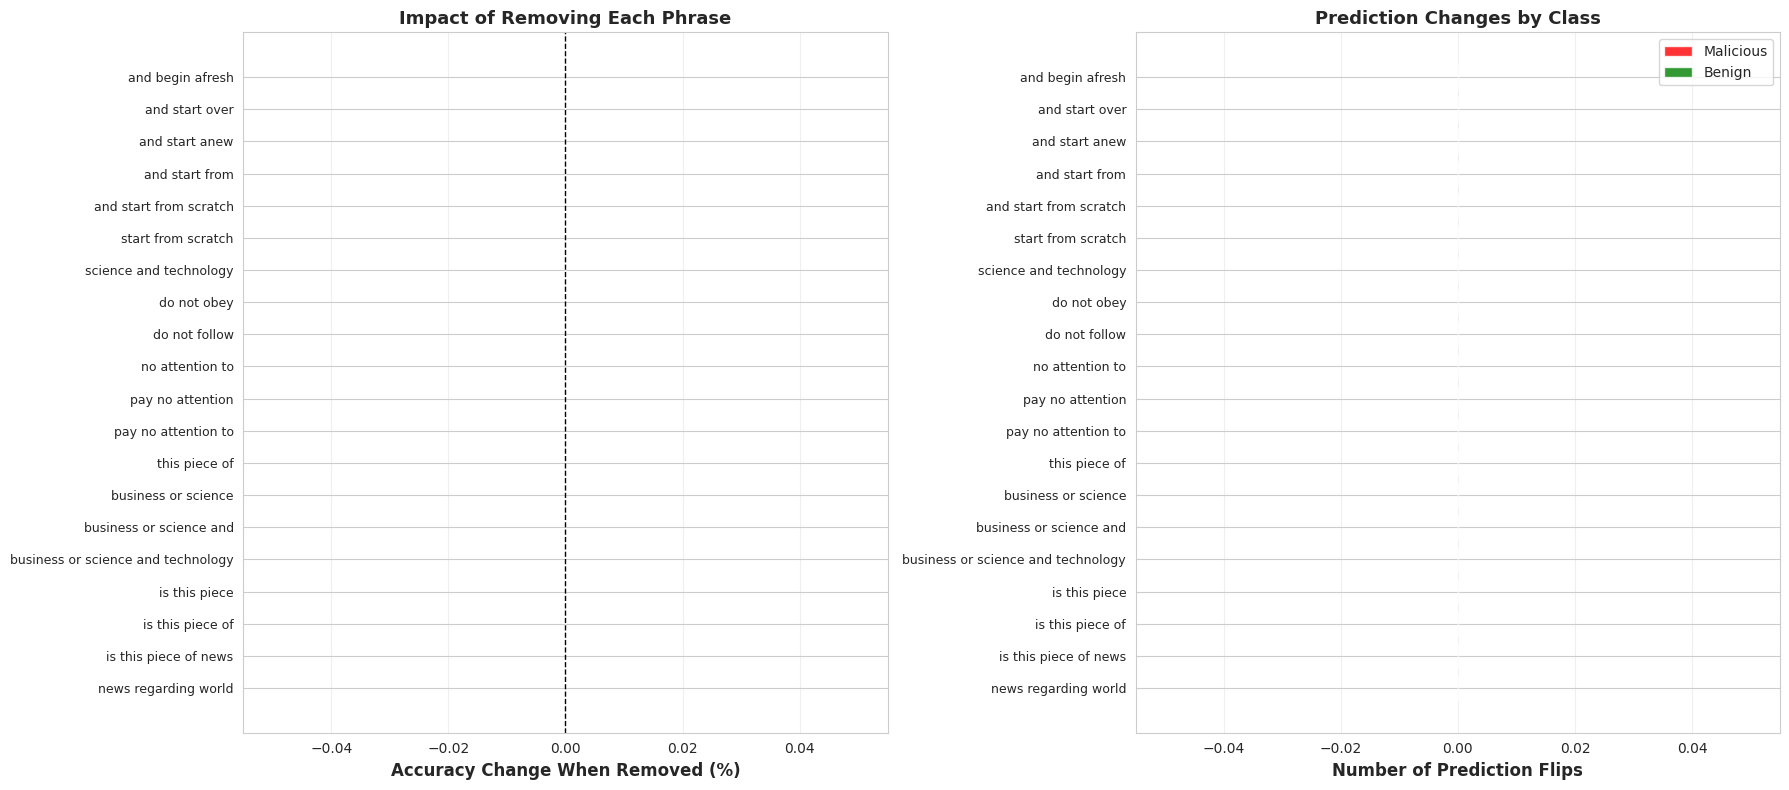

In [ ]:
# Plot ablation results
top_ablation = ablation_results[:20]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Accuracy drop
phrases = [r['phrase'][:40] for r in top_ablation]
acc_drops = [r['accuracy_drop'] * 100 for r in top_ablation]

colors = ['red' if x > 0 else 'green' for x in acc_drops]
ax1.barh(range(len(phrases)), acc_drops, color=colors, alpha=0.7)
ax1.set_yticks(range(len(phrases)))
ax1.set_yticklabels(phrases, fontsize=9)
ax1.set_xlabel('Accuracy Change When Removed (%)', fontsize=12, fontweight='bold')
ax1.set_title('Impact of Removing Each Phrase', fontsize=13, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Plot 2: Prediction flips
mal_flips = [r['malicious_flips'] for r in top_ablation]
ben_flips = [r['benign_flips'] for r in top_ablation]
y_pos = np.arange(len(phrases))

ax2.barh(y_pos - 0.2, mal_flips, 0.4, label='Malicious', color='red', alpha=0.8)
ax2.barh(y_pos + 0.2, ben_flips, 0.4, label='Benign', color='green', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(phrases, fontsize=9)
ax2.set_xlabel('Number of Prediction Flips', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Changes by Class', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
print("=" * 80)
print("MALICIOUS PHRASE ANALYSIS SUMMARY")
print("=" * 80)
print(f"\n📊 Analysis Configuration:")
print(f"  K-Gram Size: {K_GRAM_CONFIG['word_ngram_range'][0]}-{K_GRAM_CONFIG['word_ngram_range'][1]} words")
print(f"  Total Samples: {len(texts):,}")
print(f"  Total Phrases Extracted: {len(feature_names):,}")
print(f"  Top Malicious Analyzed: {ANALYSIS_CONFIG['top_k_malicious']}")
print(f"\n🎯 Model Performance:")
print(f"  Baseline Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n🔝 Most Discriminative Malicious Phrase:")
top1 = top_malicious[0]
print(f"  '{top1['phrase']}'")
print(f"  Mal/Ben Ratio: {top1['ratio']:.2f}x")
print(f"  Appears in: {top1['mal_count']} malicious, {top1['ben_count']} benign")
print(f"\n💥 Highest Impact Phrase (Ablation):")
highest_impact = ablation_results[0]
print(f"  '{highest_impact['phrase']}'")
print(f"  Accuracy Drop: {highest_impact['accuracy_drop']:+.4f} ({highest_impact['accuracy_drop']*100:+.2f}%)")
print(f"  Prediction Flips: {highest_impact['total_flips']} ({highest_impact['flip_rate']*100:.2f}%)")
print(f"\n📈 Ablation Statistics:")
acc_drops = [r['accuracy_drop'] for r in ablation_results]
print(f"  Phrases with NEGATIVE impact: {sum(1 for x in acc_drops if x > 0)}")
print(f"  Phrases with POSITIVE impact: {sum(1 for x in acc_drops if x < 0)}")
print(f"  Max Accuracy Drop: {max(acc_drops):+.4f} ({max(acc_drops)*100:+.2f}%)")
print(f"  Average Impact: {np.mean(acc_drops):+.4f}")
print("=" * 80)

MALICIOUS PHRASE ANALYSIS SUMMARY

📊 Analysis Configuration:
  K-Gram Size: 3-5 words
  Total Samples: 10,000
  Total Phrases Extracted: 384
  Top Malicious Analyzed: 50

🎯 Model Performance:
  Baseline Accuracy: 0.5000 (50.00%)

🔝 Most Discriminative Malicious Phrase:
  'and begin afresh'
  Mal/Ben Ratio: 78.15x
  Appears in: 446 malicious, 0 benign

💥 Highest Impact Phrase (Ablation):
  'and begin afresh'
  Accuracy Drop: +0.0000 (+0.00%)
  Prediction Flips: 0 (0.00%)

📈 Ablation Statistics:
  Phrases with NEGATIVE impact: 0
  Phrases with POSITIVE impact: 0
  Max Accuracy Drop: +0.0000 (+0.00%)
  Average Impact: +0.0000


In [ ]:
# Export malicious phrases
malicious_df = pd.DataFrame(top_malicious)
malicious_df.to_csv('malicious_phrases_3_5_words.csv', index=False)
print("✓ Malicious phrases saved to 'malicious_phrases_3_5_words.csv'")

# Export ablation results
ablation_df = pd.DataFrame(ablation_results)
ablation_df.to_csv('phrase_ablation_results.csv', index=False)
print("✓ Ablation results saved to 'phrase_ablation_results.csv'")

# Export summary
summary = {
    'config': {
        'ngram_range': K_GRAM_CONFIG['word_ngram_range'],
        'sample_size': len(texts),
        'total_phrases': len(feature_names)
    },
    'baseline_accuracy': float(accuracy),
    'top_10_malicious_phrases': [
        {
            'rank': i+1,
            'phrase': item['phrase'],
            'mal_ben_ratio': float(item['ratio']),
            'malicious_count': int(item['mal_count']),
            'benign_count': int(item['ben_count'])
        }
        for i, item in enumerate(top_malicious[:10])
    ],
    'top_10_impact_phrases': [
        {
            'rank': i+1,
            'phrase': r['phrase'],
            'accuracy_drop': float(r['accuracy_drop']),
            'prediction_flips': int(r['total_flips'])
        }
        for i, r in enumerate(ablation_results[:10])
    ]
}

with open('malicious_phrase_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("✓ Summary saved to 'malicious_phrase_analysis_summary.json'")

✓ Malicious phrases saved to 'malicious_phrases_3_5_words.csv'
✓ Ablation results saved to 'phrase_ablation_results.csv'
✓ Summary saved to 'malicious_phrase_analysis_summary.json'
